#Task 1: Create a CNN based model for text classification

<a name='1'></a>
# 1. CNNs for Texts

<a name='1-1'></a>
## 1.1 Getting the Data

In this practice, we will use [news dataset, `ag_news_subset`](https://www.tensorflow.org/datasets/catalog/ag_news_subset) that is available on TensorFlow datasets.

TensorFlow datasets is a collection of awesome datasets that can be used right away with little preparations.

AG is a collection of more than 1 million news articles gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity.

The AG dataset contains 4 classes that are: World(0), Sports(1), Business(2), Sci/Tech(3). The total number of training samples is 120,000 and testing 7,600. Each class contains 30,000 training samples and 1,900 testing samples.

You can learn more about the dataset [here](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), or read the orginal paper that used it to explore the use of [character-level convolutional networks (ConvNets) for text classification](https://arxiv.org/abs/1509.01626) by Xiang Zhang, Junbo Zhao, and Yann LeCun.

Let's get the dataset from TensorFlow datasets.

In [33]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

The dataset that we are going to download has only one version so far. Let's specify it so that when it is updated, our lab will not be affected. If loading the data fails, run the cell again. It happens sometime when loading datasets from TF datasets.

Orginally, the training set contains 120.000 news samples, whereas test set contain 7600 samples. Let's take 10% percent of news from training set to validation set so we can increase it a little bit.  

In [2]:
(train_data, val_data), info = tfds.load('ag_news_subset:1.0.0', #version 1.0.0
                                         split=['train[:90%]', 'train[90%:]+test'],
                                         with_info=True,
                                         as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteHE6P77/ag_news_subset-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteHE6P77/ag_news_subset-test.tfrecord*...:   …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


We can display the `info` that we loaded with dataset.

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [4]:
# Displaying the classes

class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
num_train = info.splits['train'].num_examples
num_val = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of validation samples: {num_val}')

The number of training samples: 120000 
The number of validation samples: 7600


We can also display the first 10 news samples. We can use [`tfds.as_dataframe`](https://www.tensorflow.org/datasets/api_docs/python/tfds/as_dataframe) to display them as dataframe.

In [6]:
news_df = tfds.as_dataframe(train_data.take(10), info)

news_df.head(10)

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1
5,b'TOKYO - Sony Corp. is banking on the \\$3 bi...,0
6,b'Giant pandas may well prefer bamboo to lapto...,3
7,"b'VILNIUS, Lithuania - Lithuania #39;s main pa...",0
8,b'Witnesses in the trial of a US soldier charg...,0
9,"b'Dan Olsen of Ponte Vedra Beach, Fla., shot a...",1


Let's display some full news.

In [7]:
for i in range (0,4):

  print(f"Sample news {i}\n \
  Label: {news_df['label'][i]} {(class_names[i])}\n \
  Description: {news_df['description'][i]}\n----------\n")

Sample news 0
   Label: 3 World
   Description: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
----------

Sample news 1
   Label: 1 Sports
   Description: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
----------

Sample news 2
   Label: 2 Business
   Description: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
----------

Sample news 3
   Label: 3 Sci/Tech
   Description: b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
----------



<a name='1-2'></a>

## 1.2 Preparing the Data

We can not feed the raw texts that we loaded from the tensorflow datasets to the model. We have to do some preps works.

One of the major thing we have to do is to vectorize the texts or convert them into numeric tokens.

We will use [TextVectorizer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/), but before we get there, let's first shuffle and batch the training data.

For validation data and test data, we don't shuffle. We only batch it.

In [8]:
buffer_size = 1000
batch_size = 32

train_data = train_data.shuffle(buffer_size)
train_data = train_data.batch(batch_size).prefetch(1)
val_data = val_data.batch(batch_size).prefetch(1)

In [9]:
for news, label in train_data.take(1):

  print(f'Sample news\n----\n {news.numpy()[:4]} \n----\nCorresponding labels: {label.numpy()[:4]}')

Sample news
----
 [b'Today was a day of good news for multiple sclerosis patients: FDA granted approval to a new anti-multiple sclerosis drug Antegren developed by Biogen Idec Inc.'
 b'Britain #39;s largest insurer Aviva says it plans to have moved up to 7,000 UK jobs to low-cost centres in Asia by the end of 2007, the final figure in its controversial programme to shift jobs offshore.'
 b'AP - The Atlanta Braves made another huge pitch for success, getting Tim Hudson from Oakland. And the Seattle Mariners added another slugger, grabbing Adrian Beltre off the free-agent market.'
 b'In its campaign to discredit Linux, the main rival to its Windows operating system, Microsoft (MSFT ) once published a witty print advertisement in Germany that showed four penguins standing in a row.'] 
----
Corresponding labels: [2 2 1 3]


As you can see from the above, the training data is in batches of descriptions and their corresponding labels.

Now, we can use Keras [TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/) to handle all required text preprocessing. It will convert the texts into tokens, convert them into sequences, padd the sequences. It also removes punctuations and lower the case.

That's all it does by default.

In [10]:
max_features = 10000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features)

After creating the layer, we can use `adapt` to pass the dataset throught it. Notice that we use `lambda function` to get the description separated from the label.

In [11]:
text_vectorizer.adapt(train_data.map(lambda description, label : description))

We can get the vocabulary. Vocabulary is the list of individual words making up a particular sentence.

In [12]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for']

Let's pass some new sentences to `text_vectorizer`. The vectorized sequences will be padded with the maximum sentences, but if you want to hava fixed size, you can set the `output_sequence_length` to any value in the layer initialization.

In [13]:
sample_news = ['This weekend there is a sport match between Man U and Fc Barcelona',
               'Tesla has unveiled its humanoid robot that appeared dancing during the show!']



In [14]:
vectorized_news = text_vectorizer(sample_news)
vectorized_news.numpy()

array([[  40,  494,  186,   16,    3, 1567,  570,  159,  370,    1,    7,
        7486, 2556],
       [   1,   20,  876,   13,    1, 4845,   10, 1273,    1,  160,    2,
         532,    0]])

If you can look on the above tensors, the second sentence was padded with 0. Also the words `Tesla` and `humanoid` have an indice of 1 because they were not a part of the training data (that we adapted to the `text_vectorizer`).

So this means that the indice 1 is reserved for all words that are new to the layer. In the vocabulary, these kind of words are replaced by `UNK`.

We will use `text_vectorizer` as part of the model.

<a name='1-3'></a>

## 1.3 Creating and Training the Model

We are going to create a Keras Sequential model that takes the texts input and output the class of the input texts.

The model is going to be made of the following layers:

* `TextVectorization layer` for texts preprocessing.

* `Embedding layer` for representing the tokens into a trainable feature vector of a high dimensional space. Because the feature vector is trainable, after training the words that have the same semantic meaning will end up having the same vectors (and pointing to the same directions).

* `A Conv1D` for processing the sequences. Yes, Convnets can be used for texts processing. We will start off with only Convnets, and later use RNNs as well.

* `Dense layer` for classification purpose. It takes the vector and convert it into a single logit output.

In [15]:
input_dim = len(text_vectorizer.get_vocabulary())
input_dim

10000

In [16]:
model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

Getting the model summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

We can also plot the model with Keras util's `plot_model`.

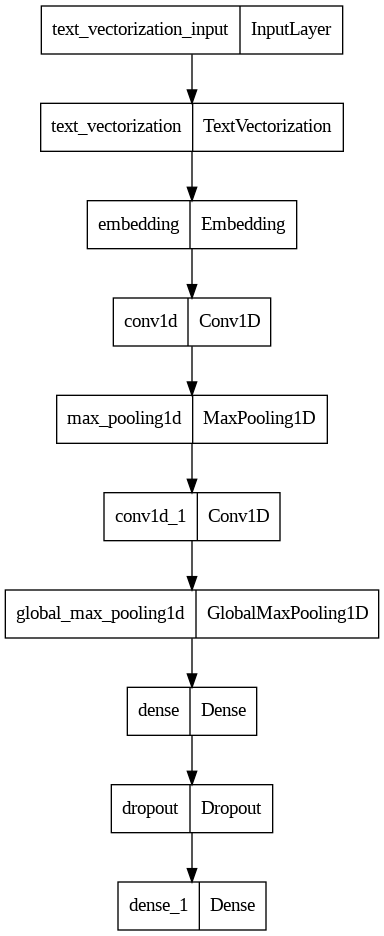

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [19]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)

In [21]:
# Train the model

history = model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 [==============================] - 30s 183ms/step - loss: 1.3674 - accuracy: 0.2964 - val_loss: 1.2487 - val_accuracy: 0.4178
Epoch 2/25
105/105 [==============================] - 9s 85ms/step - loss: 0.9329 - accuracy: 0.5976 - val_loss: 0.5343 - val_accuracy: 0.8141
Epoch 3/25
105/105 [==============================] - 5s 52ms/step - loss: 0.5950 - accuracy: 0.7920 - val_loss: 0.4493 - val_accuracy: 0.8586
Epoch 4/25
105/105 [==============================] - 4s 40ms/step - loss: 0.4825 - accuracy: 0.8393 - val_loss: 0.4171 - val_accuracy: 0.8602
Epoch 5/25
105/105 [==============================] - 2s 22ms/step - loss: 0.4462 - accuracy: 0.8539 - val_loss: 0.4060 - val_accuracy: 0.8750
Epoch 6/25
105/105 [==============================] - 3s 25ms/step - loss: 0.4252 - accuracy: 0.8592 - val_loss: 0.3633 - val_accuracy: 0.8750
Epoch 7/25
105/105 [==============================] - 3s 29ms/step - loss: 0.4249 - accuracy: 0.8649 - val_loss: 0.3705 - val_accuracy: 0.87

<a name='2-4'></a>

## 1.4 Visualizing the Results

It is always a good practice to plot the model results. When doing error analysis, plotting learning curve becomes helpful.

Let's plot the loss and accuracy over on the course of epochs.

In [22]:
import matplotlib.pyplot as plt

# function to plot accuracy and loss

def plot_acc_loss(history):

  model_history = history.history
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

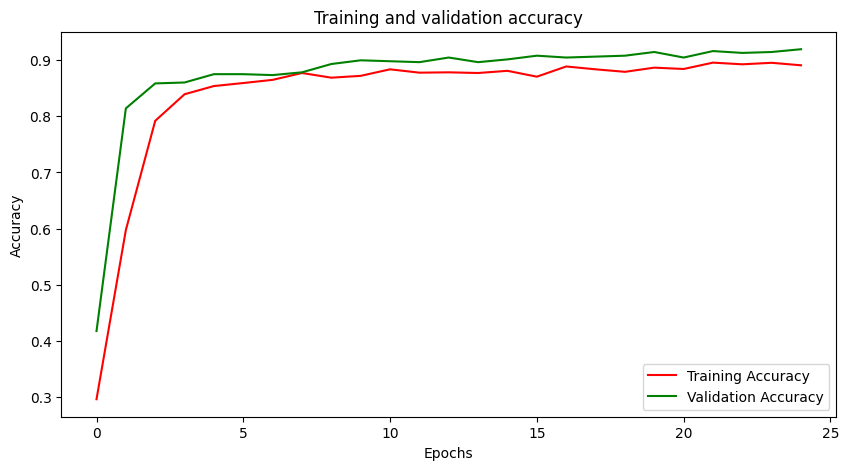

<Figure size 640x480 with 0 Axes>

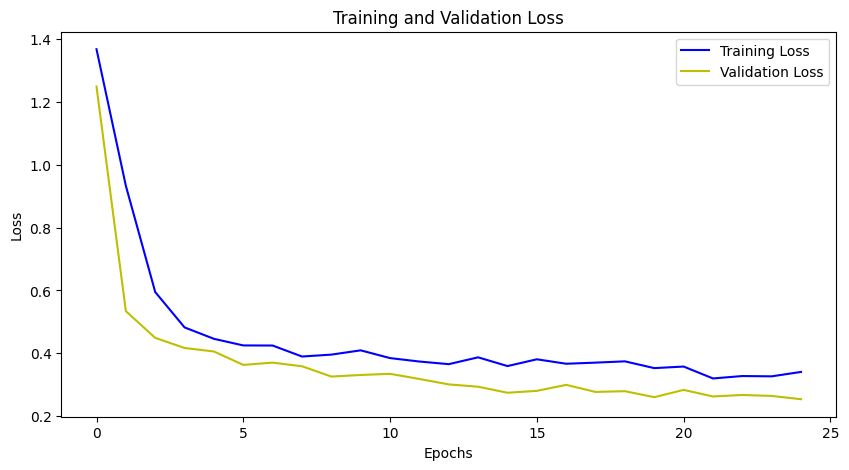

In [23]:
plot_acc_loss(history)

That's not pretty bad. Let's combine CNNs and LSTMs to see if we can improve the results further.

<a name='2'></a>

# Task 2: Combine CNN with RNN

<a name='2-1'></a>

## 2.1 Convnets and RNNs Model

In [24]:
conv_rnn_model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [25]:
conv_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          20544     
                                                                 
 bidirectional (Bidirectiona  (None, 128)             

In [26]:
# Compile the model

conv_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


# Train the model

history = conv_rnn_model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 [==============================] - 21s 137ms/step - loss: 1.2924 - accuracy: 0.3241 - val_loss: 1.0132 - val_accuracy: 0.5312
Epoch 2/25
105/105 [==============================] - 5s 45ms/step - loss: 0.9443 - accuracy: 0.5530 - val_loss: 0.8304 - val_accuracy: 0.5987
Epoch 3/25
105/105 [==============================] - 3s 26ms/step - loss: 0.7452 - accuracy: 0.7030 - val_loss: 0.5798 - val_accuracy: 0.7911
Epoch 4/25
105/105 [==============================] - 4s 34ms/step - loss: 0.5341 - accuracy: 0.8167 - val_loss: 0.4660 - val_accuracy: 0.8289
Epoch 5/25
105/105 [==============================] - 1s 12ms/step - loss: 0.4652 - accuracy: 0.8417 - val_loss: 0.4084 - val_accuracy: 0.8635
Epoch 6/25
105/105 [==============================] - 3s 27ms/step - loss: 0.4578 - accuracy: 0.8455 - val_loss: 0.3682 - val_accuracy: 0.8799
Epoch 7/25
105/105 [==============================] - 2s 17ms/step - loss: 0.4482 - accuracy: 0.8551 - val_loss: 0.3658 - val_accuracy: 0.88

<a name='3-2'></a>

## 2.2 Visualizing the Results

Plotting the model results...

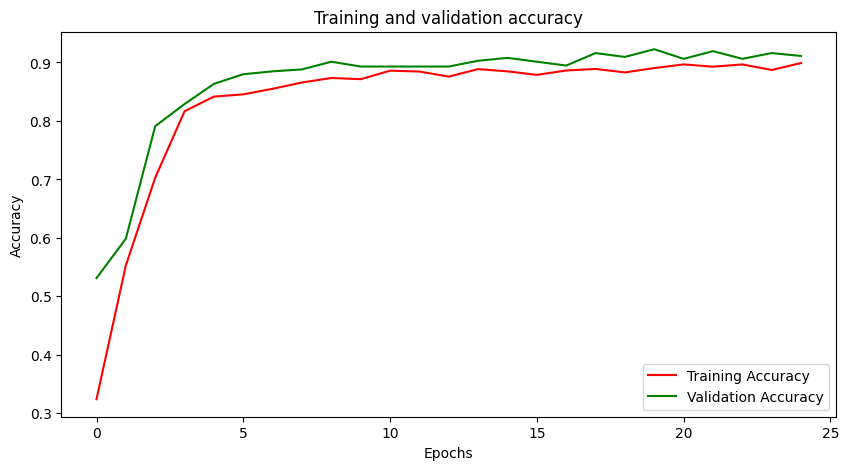

<Figure size 640x480 with 0 Axes>

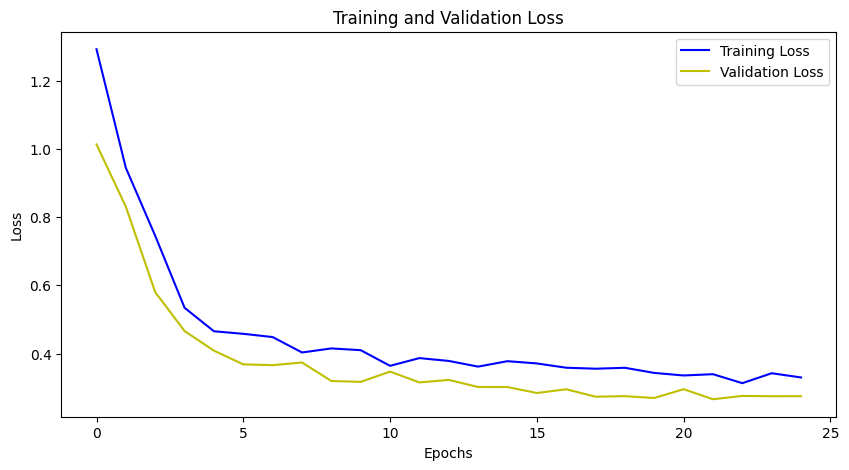

In [28]:
plot_acc_loss(history)

There is not a much difference with the former, but the results that we get by combining Convnets and RNNs are away good than using RNNs only. And in addition to that, it is cheaper to train it.

For now, let's test our later network on new texts.

<a name='2-3'></a>

## 2.3 Performing Inference on New Texts

In [29]:
def predict(model, sample_news, class_names):

  # Convert sample news into array

  sample_news = np.array(sample_news)

  # Predict the news type

  preds = model.predict(sample_news)

  pred_class = np.argmax(preds[0])

  print(f'predicted class: {pred_class} \nPredicted Class name: {class_names[pred_class]}')


In [30]:
sample_news = ['Tesla, a self driving car company is also planning to make a humanoid robot. This humanoid robot appeared dancing in the latest Tesla AI day']

predict(conv_rnn_model, sample_news, class_names)

1/1 [==============================] - 1s 934ms/step
predicted class: 2 
Predicted Class name: Business


In [31]:
sample_news = ["In the last weeks, there has been many transfer suprises in footbal. Ronaldo went back to Old Trafford, "
                "while Messi went to Paris Saint Germain to join his former colleague Neymar."
                "We can't wait to see these two clubs will perform in upcoming leagues"]


predict(conv_rnn_model, sample_news, class_names)

1/1 [==============================] - 0s 81ms/step
predicted class: 1 
Predicted Class name: Sports


In [32]:
sample_news = ["In the latest business news: The tech giant NVIDIA has acquired ARM, a microproccessor company"]


predict(conv_rnn_model, sample_news, class_names)

1/1 [==============================] - 0s 80ms/step
predicted class: 3 
Predicted Class name: Sci/Tech
